### The Goal

The goal of your project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, we'll need to perform a hypothesis test (or perhaps several) to answer the following questions:

##### Question : Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?


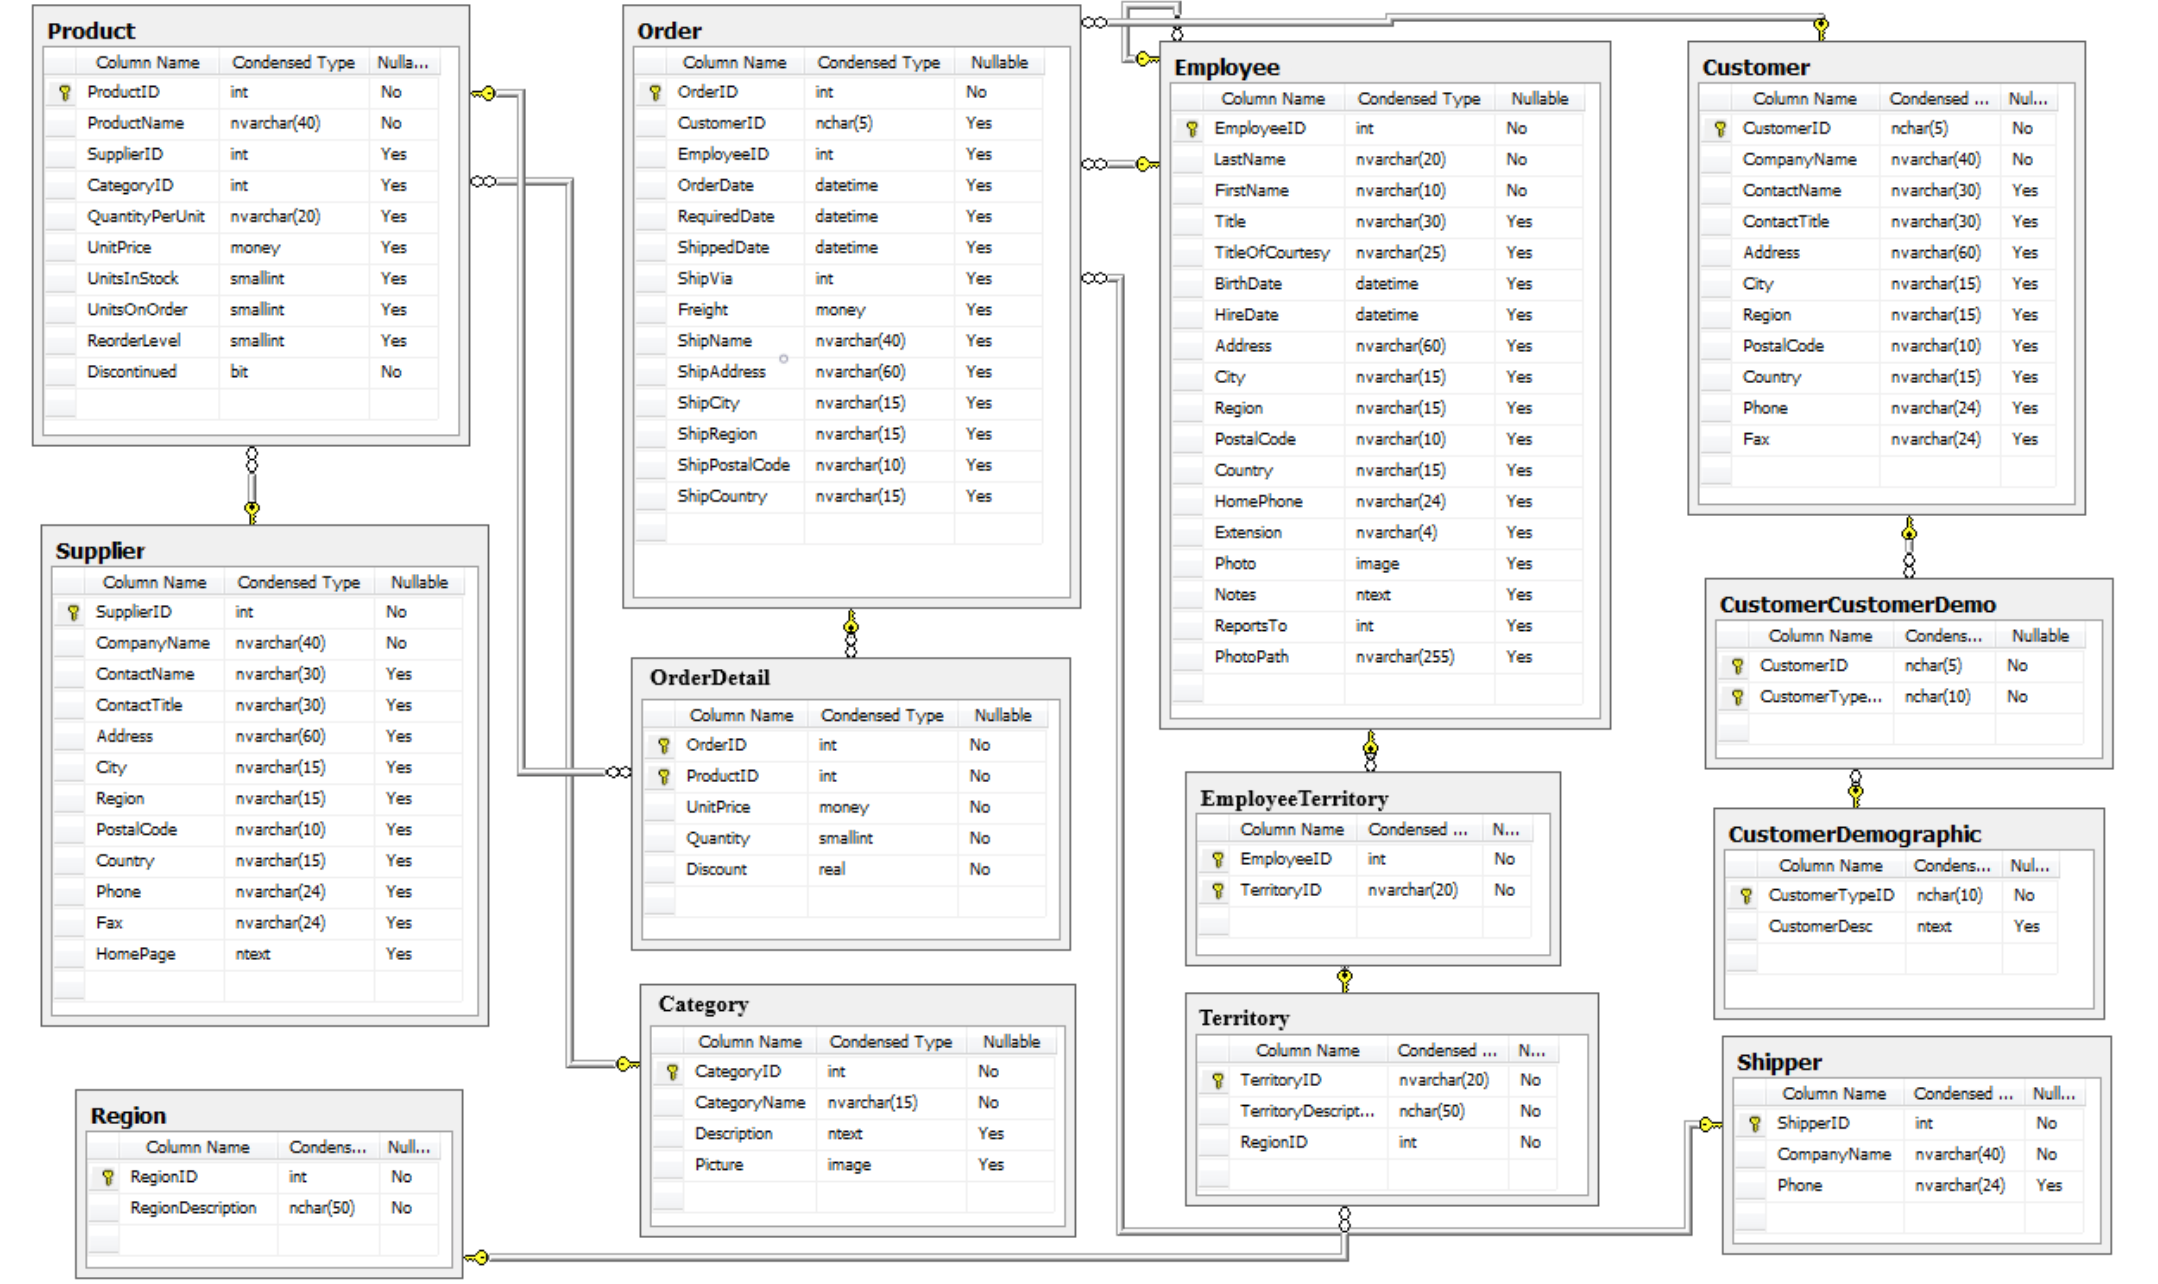

In [165]:
# Importing libraries
import sqlite3 # for database
import pandas as pd # for dataframe
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # analysis
from scipy import stats # significance levels, normality
from scipy.stats import ttest_ind
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

In [166]:
# Connecting to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [167]:
c.execute('''SELECT name as NAME FROM sqlite_master WHERE type='table';''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
print(df)

                    NAME
0               Employee
1               Category
2               Customer
3                Shipper
4               Supplier
5                  Order
6                Product
7            OrderDetail
8   CustomerCustomerDemo
9    CustomerDemographic
10                Region
11             Territory
12     EmployeeTerritory


In [168]:
c.execute('''SELECT *
              FROM Employee;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
print(df.columns)
print(df['Country'].unique())

Index(['Id', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate',
       'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country',
       'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath'],
      dtype='object')
['USA' 'UK']


In [169]:
c.execute('''SELECT *
              FROM Category;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]

print(df['Id'].unique())
print(df['CategoryName'].unique())
df

[1 2 3 4 5 6 7 8]
['Beverages' 'Condiments' 'Confections' 'Dairy Products' 'Grains/Cereals'
 'Meat/Poultry' 'Produce' 'Seafood']


,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [170]:
c.execute('''SELECT *
              FROM Product;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
#print(df[ProductName].unique())
df.head(5)
df.tail()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
72,73,Röd Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,Rhönbräu Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,Lakkalikööri,23,1,500 ml,18.00,57,0,20,0
76,77,Original Frankfurter grüne Soße,12,2,12 boxes,13.00,32,0,15,0


In [171]:
c.execute('''SELECT *
              FROM OrderDetail;''')
df = pd.DataFrame(c.fetchall()) # Create dataframe
df.columns = [i[0] for i in c.description]
product_id = np.sort(df['ProductId'].unique())
print(product_id)
df.head()
df_D_P = df.groupby(['Discount']).sum().iloc[:, 3:4]
df_D_P.T

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77]


Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
Quantity,28599,2,4,5,1,5182,2,4366,4456,4351,4349


### LOAD FROM DATABASE TABLES TO DATAFRAMES 

In [202]:
c.execute('''SELECT name as NAME FROM sqlite_master WHERE type='table';''')
df = pd.DataFrame(c.fetchall())
df[:][0]

df_all = []
for i in df[:][0]:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall() # for table i, get the metadata of table i
    df = pd.DataFrame(table, columns=[i[1] for i in columns]) # use table column names as the dataframe column names   
    df_name = i+"_df" # Assign name for each table
    exec(df_name + " = df") # => TableName_df
    # store all dataframe names in the list
    df_all.append(df_name)
    #try : Product_df, OrderDetail_df, etc.
print(df_all)


['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


### Exploratory Data Analysis - EDA:

Order quantities of disconted and not discounted products
Table Product has 77 entries, each entry is unique product
First we can check visually if discount really made a difference in order quantity


In [173]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [174]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [175]:
OrderDetail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [176]:
OrderDetail_df.isnull().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [177]:
mean_diff =  round(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'].mean()- OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'].mean(),2)
mean_diff

5.39

In [178]:
def ecdf (data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,(n+1))/n
    return x, y

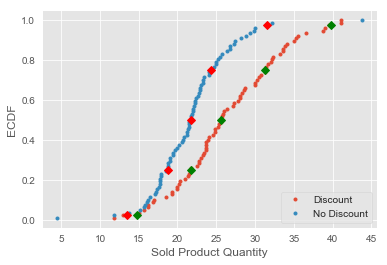

In [179]:
discount = np.array(OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean())
no_discount = np.array(OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean())
x_discount, y_discount = ecdf(discount)
x_no_discount, y_no_discount = ecdf(no_discount)

# Specify array of percentiles
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_discount = np.percentile(discount, percentiles)
ptiles_no_discount = np.percentile(no_discount, percentiles)
# Plot all ECDFs on the same plot:
_=plt.plot(x_discount, y_discount, marker = '.', linestyle = 'none')
_=plt.plot(x_no_discount, y_no_discount, marker = '.', linestyle = 'none')
_=plt.plot(ptiles_discount, percentiles/100, marker = 'D', color = 'green', linestyle = 'none')
_=plt.plot(ptiles_no_discount, percentiles/100, marker = 'D', color = 'red', linestyle = 'none')
# Annotate the plot:
_=plt.legend(('Discount', 'No Discount'), loc = 'lower right')
_=plt.xlabel('Sold Product Quantity')
_=plt.ylabel('ECDF')
plt.show()

#### CONCLUSION:

##### On average: 
* 
* 
* 
    * 
    * 



* Null Hypothesis:
    Total sold product quantity with discount <= Total sold product quantity without discount
* Alternative Hypothesis:
    Total sold product quantity with discount > Total sold product quantity without discount

In [180]:
OrderDetail_df.shape

(2155, 6)

In [181]:
OrderDetail_df[OrderDetail_df['Discount']!=0].shape, OrderDetail_df[OrderDetail_df['Discount']==0].shape

((838, 6), (1317, 6))

In [182]:
discount_sample = OrderDetail_df.sample(replace = False, n = len(OrderDetail_df[OrderDetail_df['Discount']!=0]))
discount_sample.shape

(838, 6)

In [183]:
discount_sample.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2037,11035/54,11035,54,7.45,10,0.00
1384,10774/31,10774,31,12.50,2,0.25
1038,10642/61,10642,61,28.50,20,0.20
591,10470/18,10470,18,50.00,30,0.00
1878,10977/39,10977,39,18.00,30,0.00


In [184]:
no_discount_sample = OrderDetail_df.drop(discount_sample.index, axis = 0)
no_discount_sample.shape

(1317, 6)

 ### NHAP  NHAP  NHAP  NHAP  NHAP  NHAP 

In [185]:
no_disc = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for x in ([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.15, 0.2, 0.25]):
   disc = OrderDetail_df[OrderDetail_df['Discount']==x]['Quantity']
   st, p = stats.ttest_ind(disc, no_disc)
   print(f'p-value: {p},  discount: {x}' )

p-value: nan,  discount: 0.01
p-value: 0.1116371417344615,  discount: 0.02
p-value: 0.04760884011814028,  discount: 0.03
p-value: nan,  discount: 0.04
p-value: 1.064949724167325e-05,  discount: 0.05
p-value: nan,  discount: 0.06
p-value: 0.015500606526440095,  discount: 0.1
p-value: 1.1027809944864872e-05,  discount: 0.15
p-value: 0.00032631258591041463,  discount: 0.2
p-value: 1.780928988051903e-05,  discount: 0.25


In [186]:
mean_disc = np.mean(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'])
std_disc  =  np.std(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'])                  
sample_discount = np.random.normal(mean_disc, std_disc,size = 10000)
print(mean_disc)
print(std_disc)

27.10978520286396
20.759042075141377


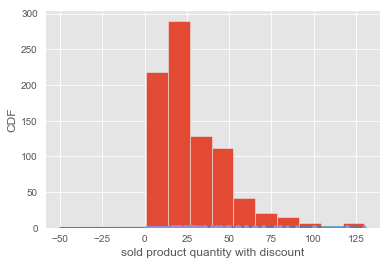

In [187]:
OrderDetail_df_discount = np.array(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'])
x1, y1 = ecdf(OrderDetail_df_discount)
x_theor, y_theor = ecdf(sample_discount)
_=plt.hist(OrderDetail_df_discount)
_=plt.plot(x_theor, y_theor)
_=plt.plot(x1,y1, marker = '.', linestyle = 'none')
_=plt.xlabel('sold product quantity with discount')
_=plt.ylabel('CDF')
plt.show()

In [188]:
mean_no_disc = np.mean(OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'])
std_no_disc  =  np.std(OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'])                  
sample_no_discount = np.random.normal(mean_no_disc, std_no_disc,size = 10000)
print(mean_no_disc)
print(std_no_disc)

21.715261958997722
17.500845477669788


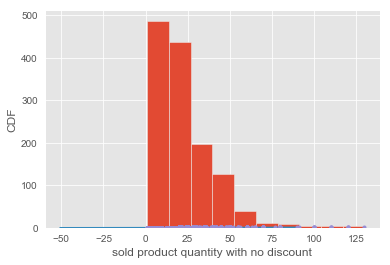

In [189]:
OrderDetail_df_no_discount = np.array(OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'])
x2, y2 = ecdf(OrderDetail_df_no_discount)
x_theor, y_theor = ecdf(sample_no_discount)
_=plt.hist(OrderDetail_df_no_discount)
_=plt.plot(x_theor, y_theor)
_=plt.plot(x2,y2, marker = '.', linestyle = 'none')
_=plt.xlabel('sold product quantity with no discount')
_=plt.ylabel('CDF')
plt.show()

#### CONCLUSION:  The dataset is not normally distributed therefore we need to use Monte Carlo simulation.

In [190]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.use('ggplot')
#plt.xkcd();

0.0


Text(0.5, 1.0, 'p value: 0.0')

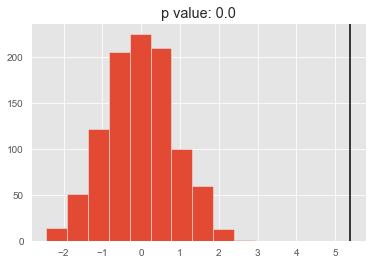

In [191]:
#%%time
mean_diff = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'].mean() - OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'].mean()
sample_diffs = []
counter = 0
for x in range(1000):
    discount_sample = OrderDetail_df.sample(replace = False, n = len(OrderDetail_df[OrderDetail_df['Discount']!=0]))
    no_discount_sample = OrderDetail_df.drop(discount_sample.index, axis = 0)
    sample_diff = discount_sample['Quantity'].mean() - no_discount_sample['Quantity'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
p = round(counter / times, 2)
print(p)
plt.title(f'p value: {p}')

In [192]:
ttest_ind(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'], OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'])

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

#### CONCLUSION:

##### On average: 
* 
* 
* 
    * 
    * 




#### Check how different between sold quantity with discount & no discount on each product ID

In [196]:
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()

#df1 = pd.DataFrame(discount).rename(columns={'Quantity': 'Discount Quantity'})
#df2 = pd.DataFrame(no_discount).rename(columns={'Quantity': 'No Discount Quantity'})

# Compare_Y_N_discount = pd.concat([df1, df2], axis=1)
# Compare_Y_N_discount['mean_diff'] = df1['Discount Quantity'] - df2['No Discount Quantity']
# Compare_Y_N_discount.info()
# Compare_Y_N_discount.head()

In [197]:
Quantity_total = OrderDetail_df.filter(['ProductId', 'Quantity', 'Discount'], axis = 1)
Quantity_total1 = Quantity_total.replace(to_replace = ['Discount'] == 0, value = 'N')
Quantity_total.head()

,ProductId,Quantity,Discount
0,11,12,0.0
1,42,10,0.0
2,72,5,0.0
3,14,9,0.0
4,51,40,0.0


(70.0, 2)
26.43
21.81


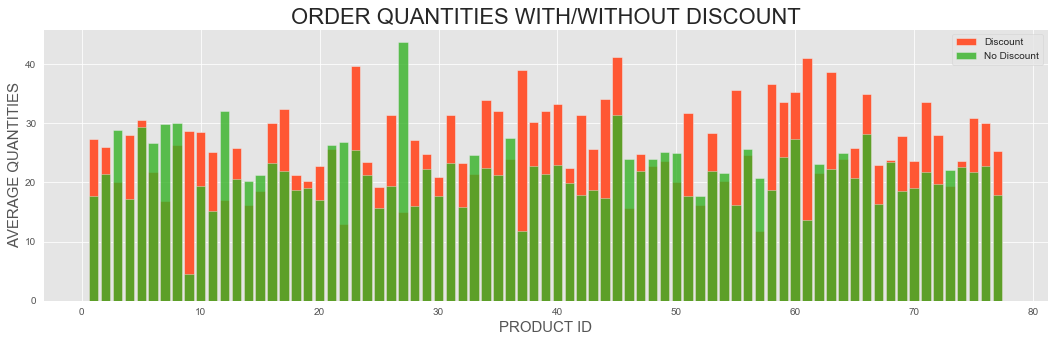

In [198]:
large_num_percentage = round(sum(discount.values > no_discount.values)/len(discount.values)*100),2
discount_mean = round(discount.values.mean(),2)
no_discount_mean = round(no_discount.values.mean(),2)
print(large_num_percentage)
print(discount_mean)
print(no_discount_mean)

plt.figure(figsize=(18,5))
plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='#FF5733')
plt.bar(no_discount.index, no_discount.values, alpha=0.8, label='No Discount', color='#35B226')
plt.title('ORDER QUANTITIES WITH/WITHOUT DISCOUNT', size=22)
plt.xlabel('PRODUCT ID', size=15)
plt.ylabel('AVERAGE QUANTITIES', size=15)
plt.legend()
plt.show()

#### CONCLUSION:

##### On average: 
* Total product items were sold with discounts is more than Total product items were sold without discounts 5.39%
* 70% of product items were sold with discounts which are larger than without discounts.
* Average on order quantities
    * with discounts:    26.43 items.
    * with no discounts: 21.81 items.


### Orders grouped by discount level

First lets see how many discounts we have and how many orders on average each discont level provides


In [199]:
c.execute('''SELECT *
              FROM OrderDetail;''')
df = pd.DataFrame(c.fetchall()) # Create dataframe
df.columns = [i[0] for i in c.description]
product_id = np.sort(df['ProductId'].unique())
print(product_id)
df.head()
df_D_P = df.groupby(['Discount']).sum().iloc[:, 3:4]
df_D_P.T



[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77]


Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
Quantity,28599,2,4,5,1,5182,2,4366,4456,4351,4349


In [208]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [207]:
df_by_discount_levels = OrderDetail_df.groupby(['Discount']).sum().iloc[:, 3:4]
df_by_discount_levels.T

Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
Quantity,28599,2,4,5,1,5182,2,4366,4456,4351,4349


group1: (1, 2, 3, 4, 6)
group2: (5, 10, 15, 20, 25)

In [209]:
# Each group is a DataFrame containing orders with certain discount level
discounts = OrderDetail_df['Discount'].unique()
groups = {}
for i in discounts:
    groups[i] = OrderDetail_df[OrderDetail_df['Discount']==i]
    groups


In [212]:
# Create new DataFrame with Discounts and Order quantities
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)

discounts_df


,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,15.0,157.0,28.382166
2,5.0,185.0,28.010811
3,20.0,161.0,27.024845
4,25.0,154.0,28.240260
5,10.0,173.0,25.236994
6,2.0,2.0,2.000000
7,3.0,3.0,1.666667
8,4.0,1.0,1.000000
9,6.0,1.0,2.000000


#### CONCLUSION:

At discount levels: 1%, 2%, 3%, 4% and 6% There are no significantly product quantity was sold. Making conclusion on those discount levels will not reflect precisely on sales. However, we should do a research to make sure that running those discount level still a need for new product launching or marketing strategy, other while we should stop. Lets drop these discount levels from our experiment.

### Bootstrap

Bootstrapping is a type of resampling where large numbers of smaller samples of the same size are repeatedly drawn, with replacement, from a single original sample.


In [85]:
def bootstrap(sample, n):
    bootstrap_sampling_dist = []
    for i in range(n):
        bootstrap_sampling_dist.append(np.random.choice(sample, size=len(sample), replace=True).mean())
    return np.array(bootstrap_sampling_dist)


### Cohen's d

Cohen's d is an effect size used to indicate the standardised difference between two means. It can be used, for example, to accompany reporting of t-test and ANOVA results. It is also widely used in meta-analysis. Cohen's d is an appropriate effect size for the comparison between two means.

In [154]:
# Computing Cohen's d function
def Cohen_d(experimental, control):

    diff = experimental.mean() - control.mean()
    n1, n2 = len(experimental), len(control)
    var1 = experimental.var()
    var2 = control.var()
    d = diff / np.sqrt((n1 * var1 + n2 * var2) / (n1 + n2))
    
    return abs(d)


### VISUALIZATION

In [162]:
# Visualization function
def visualization(no_discount, discount):
    
    plt.figure(figsize = (10,6))
    sns.distplot(discount,    bins = 50,  label =    'discount', color = '#FF33FC')
    sns.distplot(no_discount, bins = 50,  label = 'no_discount', color = 'b')

    plt.axvline(x =    discount.mean(), color = '#FF33FC', linestyle = '--')
    plt.axvline(x = no_discount.mean(), color = 'b', linestyle = '--')

    plt.title('NO DISCOUNT & DISCOUNT SAMPLING DISTRIBUTIONS', fontsize = 16)
    plt.xlabel('DISTRIBUTIONS')
    plt.ylabel('FREQUENCY')
    plt.legend()
    plt.show()


### Question

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

$H_0$: there is no difference in order quantity due to discount

$H_\alpha$: there is an increase in order quantity due to discount

Usually discount increases order quantity, so it would be reasonable to perform one-tailed test with $\alpha$ set to 0.025. If $p$ < $\alpha$, we reject null hypothesis.


### Welch's T-test

In statistics, Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to test the hypothesis that two populations have equal means.
At first I created two distributions (control and experimental). Control distribution uncludes only order quantities without discount only, and experimental distribution includes order quantities with discount (at any level)
This experiment would answer a question if there is any difference in purchase quantity


Reject Null Hypothesis
Cohen's d: 0.2862724481729283


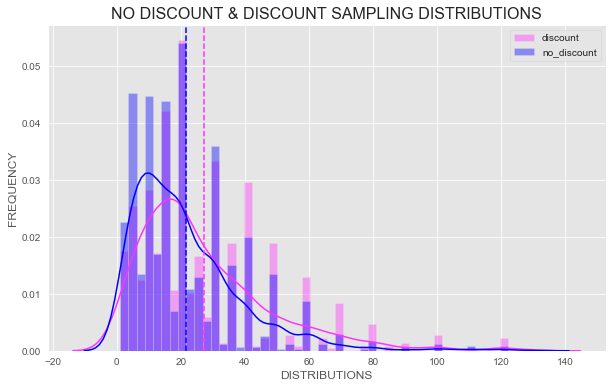

In [163]:
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
discount = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

t_stat, p = stats.ttest_ind(no_discount, discount)
d = Cohen_d(discount, no_discount)

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d)
visualization(no_discount, discount)


Result of the experiment shows that there is a statistically significant difference in orders quantities, hence we reject null hypothesis
The question is posed in the way that it is asking if order quantity is different at the different discount level.
The following step in the research would be to answer the question about at what discount level we see statisticaly significant difference in orders quantities
We will follow the same process as previous experiment, but this time we'll break our experimental group into discount amounts


In [140]:
discounts_significance_df = pd.DataFrame(columns=['Discount %', 'p value','Null Hypothesis', 'Cohens d'], index=None)

discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for i in discounts:
    discount = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(no_discount, discount)
    d = Cohen_d(no_discount, discount)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'p value': p, 'Null Hypothesis' : 'Reject' if p < 0.025 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discounts_significance_df


,Discount %,p value,Null Hypothesis,Cohens d
0,5.0%,0.000011,Reject,0.346877
1,10.0%,0.015501,Reject,0.195942
2,15.0%,0.000011,Reject,0.372404
3,20.0%,0.000326,Reject,0.300712
4,25.0%,0.000018,Reject,0.366593


### Statistically significant difference between discount levels

$H_0$: there is no difference in order quantity between discounts

$H_\alpha$: there is a difference in order quantity between discounts


In [141]:
discount_levels = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
comb = itertools.combinations(discount_levels, 2)
discount_levels_df = pd.DataFrame(columns=['Discount %', 'p value','Null Hypothesis','Cohens d'], index=None)

for i in comb:
    
    no_discount = OrderDetail_df[OrderDetail_df['Discount']==i[0]]['Quantity']
    discount    = OrderDetail_df[OrderDetail_df['Discount']==i[1]]['Quantity']
    
    st, p = stats.ttest_ind(no_discount, discount)
    d = Cohen_d(no_discount, discount)
    
    discount_levels_df = discount_levels_df.append( { 'Discount %' : str(i[0]*100)+'% - '+str(i[1]*100)+'%', 'p value': p, 'Null Hypothesis' : 'Reject' if p < 0.05 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discount_levels_df.sort_values('Cohens d', ascending=False)


,Discount %,p value,Null Hypothesis,Cohens d
4,10.0% - 15.0%,0.176421,Failed,0.149332
6,10.0% - 25.0%,0.191081,Failed,0.145146
0,5.0% - 10.0%,0.227824,Failed,0.127769
5,10.0% - 20.0%,0.416912,Failed,0.089008
7,15.0% - 20.0%,0.543396,Failed,0.068234
9,20.0% - 25.0%,0.580147,Failed,0.062415
2,5.0% - 20.0%,0.658742,Failed,0.047644
1,5.0% - 15.0%,0.874302,Failed,0.017179
3,5.0% - 25.0%,0.921297,Failed,0.010786
8,15.0% - 25.0%,0.951441,Failed,0.006912


### CONCLUSION:

* There is a significantly positively effect of discount on sales
* Discounts of 5%, 15%, 20% and 25% have approximately the same effect on order quantity


### MORE RESEARCH:


* Compare sales between Employees from US and from UK. 

* Is there any difference in demand of produce, check sales on disproduce products

* with the relatively same discount program were given across categories, is there any difference between categories sales

* Research further what clients responded better to discount

* Find out optimal level of discount for products according to their price and possible seasonal demand

* Performance of shipping companies, logistics solution